Epoch 0, Loss: 405.95184
Epoch 100, Loss: -77.66847
Epoch 200, Loss: -78.20992
Epoch 300, Loss: -78.86198
Epoch 400, Loss: -80.43938
Epoch 500, Loss: -80.91023
Epoch 600, Loss: -81.61504
Epoch 700, Loss: -81.69215
Epoch 800, Loss: -80.66993
Epoch 900, Loss: -81.61483


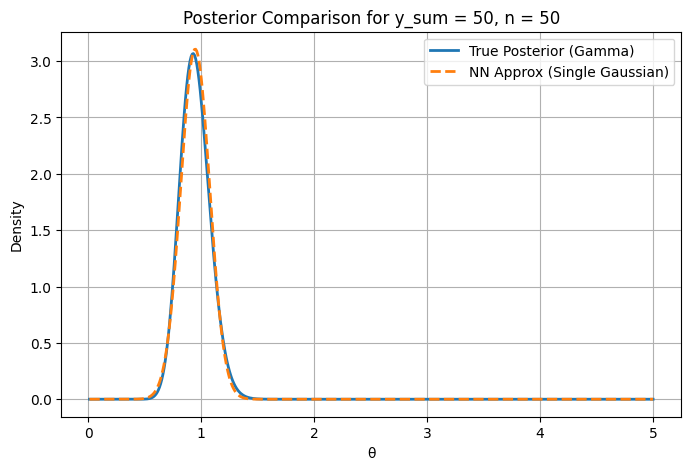

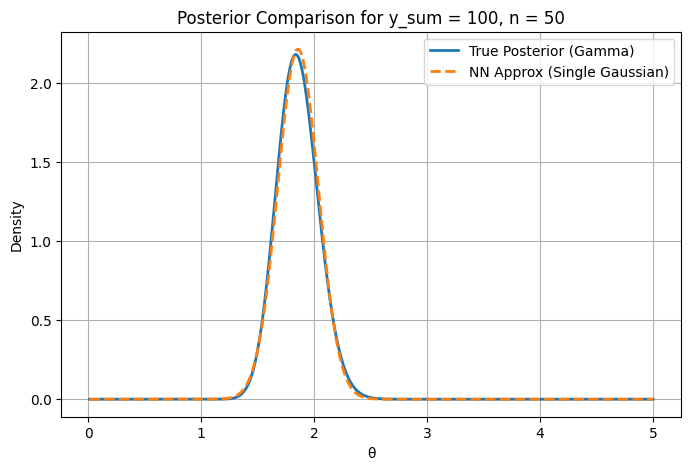

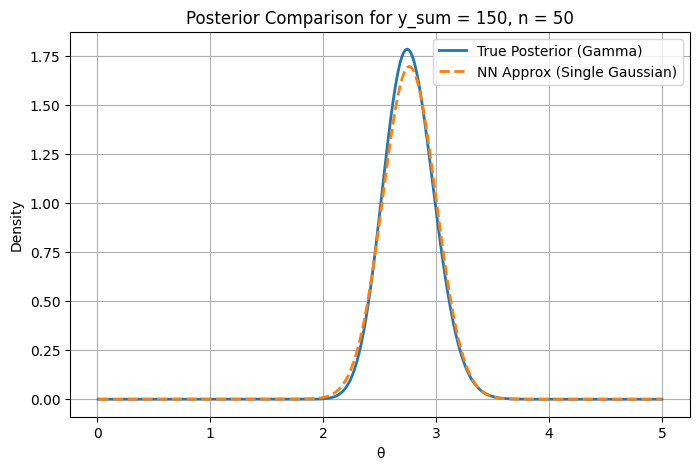

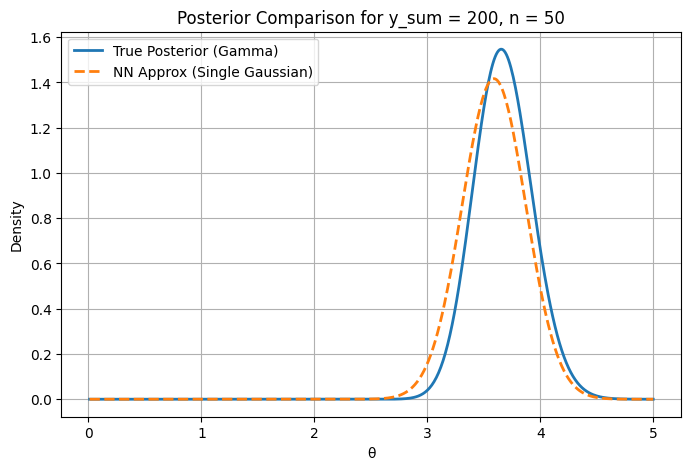

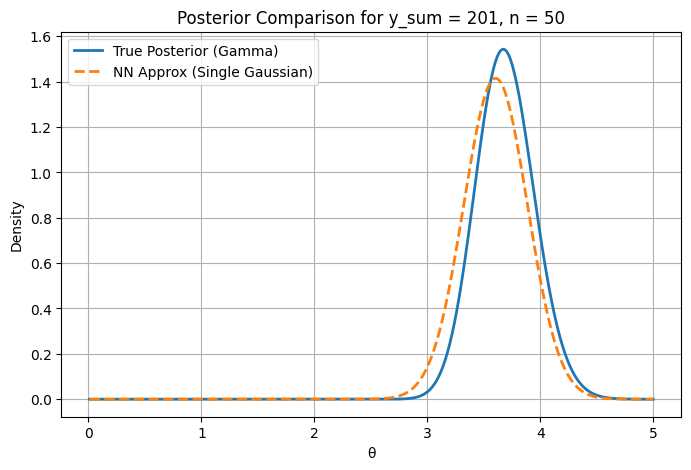

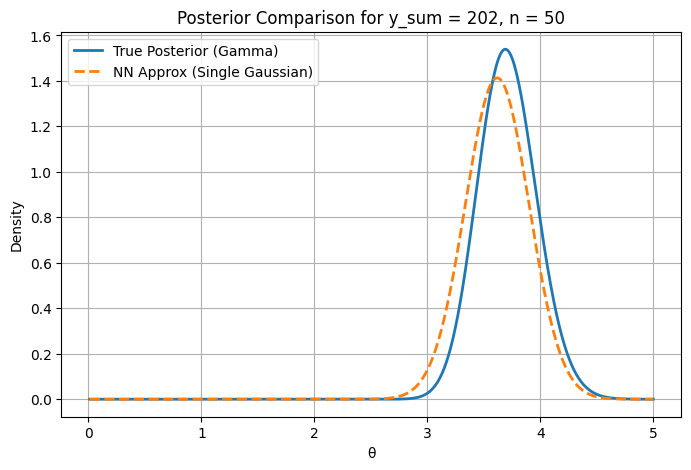

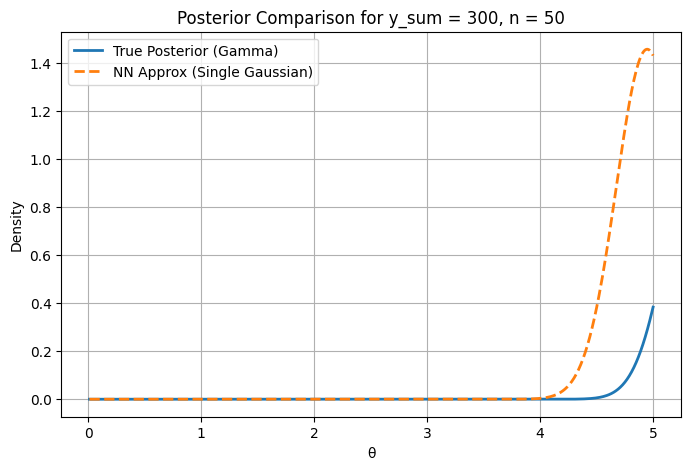

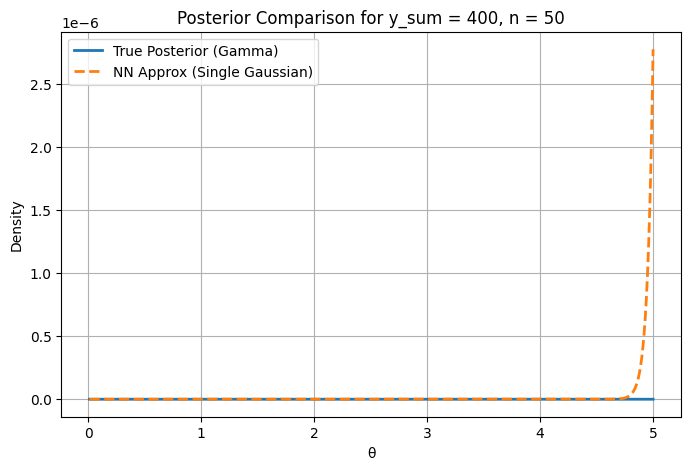

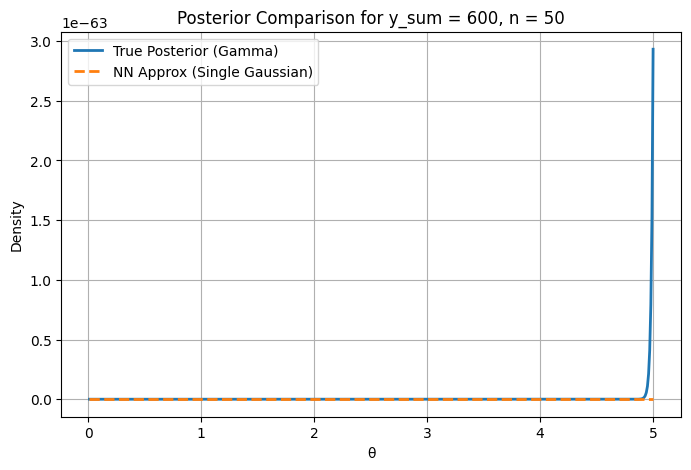

In [6]:
import random
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma

# ---------------------------
# Set seed for reproducibility
# ---------------------------
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ---------------------------
# Prior parameters
# ---------------------------
alpha = 2
beta_prior = 5
M = 10000000
n_fixed = 50  # fixed value of n

# ---------------------------
# Simulate (theta, y_sum) data
# ---------------------------
theta_vec = np.random.gamma(shape=alpha, scale=1 / beta_prior, size=M)
y_sum_vec = [np.sum(np.random.poisson(lam=theta, size=n_fixed)) for theta in theta_vec]
df = pd.DataFrame({'theta': theta_vec, 'y_sum': y_sum_vec})

# ---------------------------
# Normalize y_sum
# ---------------------------
y_max = df['y_sum'].max()
df['y_norm'] = df['y_sum'] / y_max

# ---------------------------
# Prepare training pairs (y_sum, theta samples)
# ---------------------------
unique_y = df['y_sum'].unique()
train_data = []
for y_val in unique_y:
    theta_arr = df[df['y_sum'] == y_val]['theta'].values
    if len(theta_arr) >= 2 and np.var(theta_arr) > 0:
        train_data.append((y_val / y_max, theta_arr))

# ---------------------------
# Define Single Gaussian NN
# ---------------------------
class SingleGaussianNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32), nn.ReLU(),
            nn.Linear(32, 16), nn.ReLU(),
        )
        self.mu_head = nn.Linear(16, 1)
        self.log_var_head = nn.Linear(16, 1)

    def forward(self, x):
        h = self.net(x)
        mu = self.mu_head(h)
        log_var = self.log_var_head(h)
        return mu, log_var

# ---------------------------
# Negative Log Likelihood Loss for Gaussian
# ---------------------------
def gaussian_neg_log_likelihood(theta_vals, mu, log_var):
    var = torch.exp(log_var)
    log_probs = -0.5 * (log_var + np.log(2 * np.pi) + (theta_vals - mu) ** 2 / var)
    return -log_probs.mean()

# ---------------------------
# Train the model
# ---------------------------
model = SingleGaussianNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1000):
    model.train()
    total_loss = 0.0
    for y_norm, theta_arr in train_data:
        x_input = torch.tensor([[y_norm]], dtype=torch.float32)
        theta_vals = torch.tensor(theta_arr, dtype=torch.float32).view(-1, 1)

        mu, log_var = model(x_input)
        loss = gaussian_neg_log_likelihood(theta_vals, mu, log_var)
        total_loss += loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss.item():.5f}")

# ---------------------------
# Test the model on various y_sum values
# ---------------------------
test_y_list = [50, 100, 150, 200,201,202, 300, 400, 600]
theta_range = np.linspace(0.01, 5.0, 500)

for y_obs in test_y_list:
    x_test = torch.tensor([[y_obs / y_max]], dtype=torch.float32)
    
    with torch.no_grad():
        mu, log_var = model(x_test)
        mu = mu.item()
        std = np.sqrt(np.exp(log_var.item()))

    # NN approximation (Single Gaussian)
    approx_pdf = norm.pdf(theta_range, loc=mu, scale=std)

    # True posterior (Gamma)
    alpha_post = alpha + y_obs
    beta_post = beta_prior + n_fixed
    true_pdf = gamma.pdf(theta_range, a=alpha_post, scale=1 / beta_post)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(theta_range, true_pdf, label="True Posterior (Gamma)", lw=2)
    plt.plot(theta_range, approx_pdf, label="NN Approx (Single Gaussian)", lw=2, linestyle="--")
    plt.title(f"Posterior Comparison for y_sum = {y_obs}, n = {n_fixed}")
    plt.xlabel("θ")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()


Generating training data...
Data range - y_sum: [0, 187]
Data range - theta: [0.000, 3.524]
Normalization - y_sum: mean=19.99, std=14.81
Normalization - theta: mean=0.400, std=0.283
Created 121 training groups
Training model...
Epoch 0, Loss: 0.27641, LR: 0.001000
Epoch 200, Loss: 0.00041, LR: 0.001000
Epoch 400, Loss: 0.00008, LR: 0.001000
Epoch 600, Loss: 0.00011, LR: 0.000640
Early stopping at epoch 726
Testing model...
y_sum=50: Predicted μ=0.400, σ=0.283
  True: μ=0.945, σ=0.131
y_sum=100: Predicted μ=0.400, σ=0.283
  True: μ=1.855, σ=0.184
y_sum=150: Predicted μ=0.400, σ=0.283
  True: μ=2.764, σ=0.224
y_sum=200: Predicted μ=0.400, σ=0.283
  True: μ=3.673, σ=0.258
y_sum=250: Predicted μ=0.400, σ=0.283
  True: μ=4.582, σ=0.289
y_sum=300: Predicted μ=0.400, σ=0.283
  True: μ=5.491, σ=0.316
y_sum=400: Predicted μ=0.400, σ=0.283
  True: μ=7.309, σ=0.365


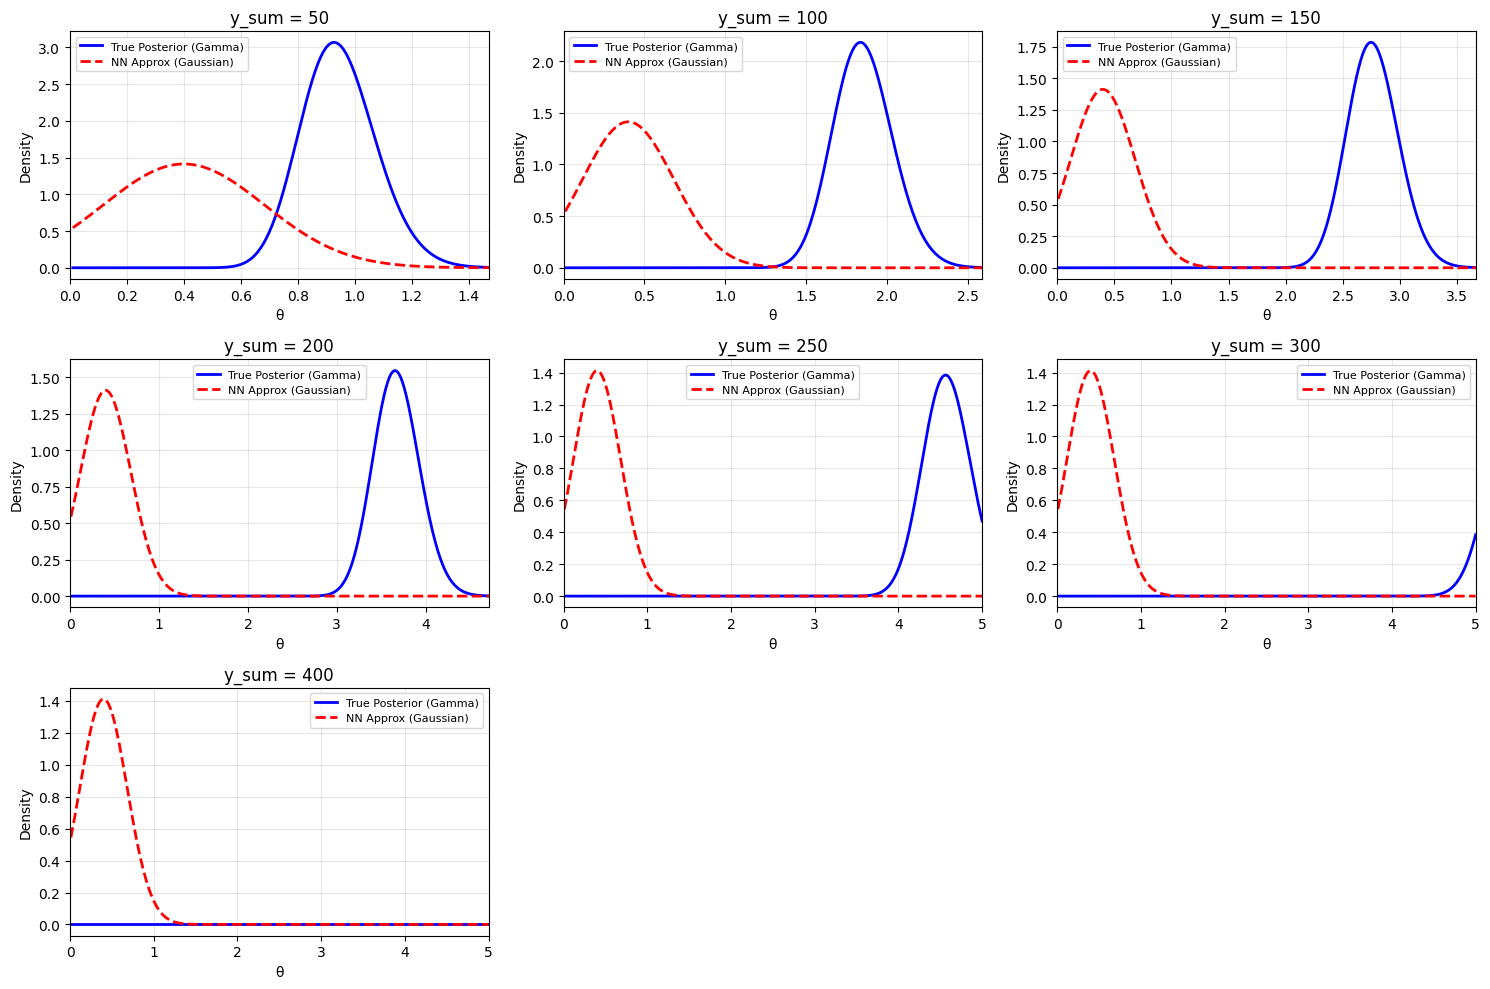


Model diagnostics:
Final training loss: 0.00001

Model predictions for normalized inputs:
  y_sum≈-10 → μ=0.400, σ=0.283
  y_sum≈-3 → μ=0.400, σ=0.283
  y_sum≈4 → μ=0.400, σ=0.283
  y_sum≈10 → μ=0.400, σ=0.283
  y_sum≈17 → μ=0.400, σ=0.283
  y_sum≈23 → μ=0.400, σ=0.283
  y_sum≈30 → μ=0.400, σ=0.283
  y_sum≈36 → μ=0.400, σ=0.283
  y_sum≈43 → μ=0.400, σ=0.283
  y_sum≈50 → μ=0.400, σ=0.283


In [8]:
### Claude version 
import random
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma

# ---------------------------
# Set seed for reproducibility
# ---------------------------
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ---------------------------
# Prior parameters
# ---------------------------
alpha = 2
beta_prior = 5
M = 1000000  # Reduced from 10M for efficiency
n_fixed = 50  # fixed value of n

print("Generating training data...")

# ---------------------------
# Simulate (theta, y_sum) data
# ---------------------------
theta_vec = np.random.gamma(shape=alpha, scale=1 / beta_prior, size=M)
y_sum_vec = [np.sum(np.random.poisson(lam=theta, size=n_fixed)) for theta in theta_vec]
df = pd.DataFrame({'theta': theta_vec, 'y_sum': y_sum_vec})

print(f"Data range - y_sum: [{df['y_sum'].min()}, {df['y_sum'].max()}]")
print(f"Data range - theta: [{df['theta'].min():.3f}, {df['theta'].max():.3f}]")

# ---------------------------
# Better normalization strategy
# ---------------------------
y_mean = df['y_sum'].mean()
y_std = df['y_sum'].std()
df['y_norm'] = (df['y_sum'] - y_mean) / y_std

theta_mean = df['theta'].mean()
theta_std = df['theta'].std()
df['theta_norm'] = (df['theta'] - theta_mean) / theta_std

print(f"Normalization - y_sum: mean={y_mean:.2f}, std={y_std:.2f}")
print(f"Normalization - theta: mean={theta_mean:.3f}, std={theta_std:.3f}")

# ---------------------------
# Prepare training data more efficiently
# ---------------------------
# Use binning for efficiency
n_bins = 200
df['y_bin'] = pd.cut(df['y_sum'], bins=n_bins, labels=False)

train_data = []
for bin_idx in range(n_bins):
    mask = df['y_bin'] == bin_idx
    if mask.sum() >= 10:  # Need sufficient samples
        theta_arr = df[mask]['theta_norm'].values
        y_norm_val = df[mask]['y_norm'].iloc[0]  # Use first value as representative
        
        if len(theta_arr) >= 10 and np.var(theta_arr) > 1e-6:
            # Sample subset for efficiency
            if len(theta_arr) > 100:
                theta_arr = np.random.choice(theta_arr, size=100, replace=False)
            train_data.append((y_norm_val, theta_arr))

print(f"Created {len(train_data)} training groups")

# ---------------------------
# Improved Neural Network Architecture
# ---------------------------
class ImprovedGaussianNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64), 
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32), 
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 16), 
            nn.ReLU(),
        )
        self.mu_head = nn.Linear(16, 1)
        self.log_var_head = nn.Linear(16, 1)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        h = self.net(x)
        mu = self.mu_head(h)
        # Constrain log_var to reasonable range
        log_var = torch.clamp(self.log_var_head(h), min=-10, max=3)
        return mu, log_var

# ---------------------------
# Improved Loss Function
# ---------------------------
def improved_gaussian_neg_log_likelihood(theta_vals, mu, log_var, weight=1.0):
    var = torch.exp(log_var)
    # Add small epsilon for numerical stability
    var = var + 1e-8
    
    # Compute log likelihood
    log_probs = -0.5 * (log_var + np.log(2 * np.pi) + (theta_vals - mu) ** 2 / var)

    # Add regularization to prevent extreme values
    reg_loss = 0.01 * (mu ** 2).mean() + 0.01 * torch.abs(log_var).mean()
    
    return  reg_loss

# ---------------------------
# Train the model with improvements
# ---------------------------
print("Training model...")
model = ImprovedGaussianNN()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.8)

best_loss = float('inf')
patience_counter = 0

for epoch in range(2000):
    model.train()
    total_loss = 0.0
    
    # Shuffle training data
    shuffled_data = train_data.copy()
    random.shuffle(shuffled_data)
    
    for y_norm, theta_arr in shuffled_data:
        x_input = torch.tensor([[y_norm]], dtype=torch.float32)
        theta_vals = torch.tensor(theta_arr, dtype=torch.float32).view(-1, 1)
        
        # Weight by sample size
        weight = np.sqrt(len(theta_arr)) / 10.0
        
        mu, log_var = model(x_input)
        loss = improved_gaussian_neg_log_likelihood(theta_vals, mu, log_var, weight)
        total_loss += loss

    optimizer.zero_grad()
    total_loss.backward()
    
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()
    
    current_loss = total_loss.item()
    scheduler.step(current_loss)
    
    # Early stopping
    if current_loss < best_loss:
        best_loss = current_loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter > 100:
        print(f"Early stopping at epoch {epoch}")
        break

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {current_loss:.5f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

# ---------------------------
# Test the model on various y_sum values
# ---------------------------
print("Testing model...")
test_y_list = [50, 100, 150, 200, 250, 300, 400]
theta_range = np.linspace(0.01, 5.0, 500)

plt.figure(figsize=(15, 10))

for i, y_obs in enumerate(test_y_list):
    # Normalize test input
    y_norm_test = (y_obs - y_mean) / y_std
    x_test = torch.tensor([[y_norm_test]], dtype=torch.float32)
    
    model.eval()
    with torch.no_grad():
        mu_norm, log_var = model(x_test)
        # Denormalize mu
        mu = mu_norm.item() * theta_std + theta_mean
        std = np.sqrt(np.exp(log_var.item())) * theta_std

    print(f"y_sum={y_obs}: Predicted μ={mu:.3f}, σ={std:.3f}")

    # NN approximation (Single Gaussian)
    approx_pdf = norm.pdf(theta_range, loc=mu, scale=std)

    # True posterior (Gamma)
    alpha_post = alpha + y_obs
    beta_post = beta_prior + n_fixed
    true_pdf = gamma.pdf(theta_range, a=alpha_post, scale=1 / beta_post)
    
    # True posterior statistics
    true_mean = alpha_post / beta_post
    true_var = alpha_post / (beta_post ** 2)
    
    print(f"  True: μ={true_mean:.3f}, σ={np.sqrt(true_var):.3f}")

    # Plot
    plt.subplot(3, 3, i + 1)
    plt.plot(theta_range, true_pdf, label="True Posterior (Gamma)", lw=2, color='blue')
    plt.plot(theta_range, approx_pdf, label="NN Approx (Gaussian)", lw=2, linestyle="--", color='red')
    plt.title(f"y_sum = {y_obs}")
    plt.xlabel("θ")
    plt.ylabel("Density")
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # Set reasonable axis limits
    plt.xlim(0, min(5, true_mean + 4*np.sqrt(true_var)))

plt.tight_layout()
plt.show()

# ---------------------------
# Additional diagnostics
# ---------------------------
print("\nModel diagnostics:")
print(f"Final training loss: {best_loss:.5f}")

# Check if model learned reasonable mappings
test_inputs = np.linspace(-2, 2, 10)  # normalized y values
print("\nModel predictions for normalized inputs:")
model.eval()
with torch.no_grad():
    for y_norm in test_inputs:
        x_test = torch.tensor([[y_norm]], dtype=torch.float32)
        mu_norm, log_var = model(x_test)
        mu = mu_norm.item() * theta_std + theta_mean
        std = np.sqrt(np.exp(log_var.item())) * theta_std
        y_orig = y_norm * y_std + y_mean
        print(f"  y_sum≈{y_orig:.0f} → μ={mu:.3f}, σ={std:.3f}")